In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import math
import random
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl

from pong.pong import games_generator
from pong.renderer import Renderer

from matplotlib import cm

tf.enable_eager_execution()

In [5]:
get_game = games_generator(40, 40, 256, 0.85)

In [6]:
_, (frame, _) = next(get_game)

(40, 40)

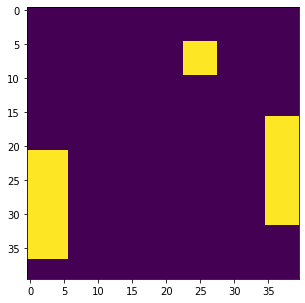

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(frame[120])
frame[120].shape

In [9]:
i = tf.keras.layers.Input((40, 40), name='input')
e = i
e = tf.keras.layers.Reshape((40, 40, 1))(e)
e = tf.keras.layers.Conv2D(32, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(128, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Reshape((3 * 3 * 128,), name='flatten')(e)
e = tf.keras.layers.Dense(32)(e)

d = e
d = tf.keras.layers.Dense(1024)(d)
d = tf.keras.layers.Reshape((1, 1, 1024))(d)
d = tf.keras.layers.Conv2DTranspose(128, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(64, (5, 5), activation='relu', strides=1)(d)
d = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(1, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Reshape((40, 40), name='frame')(d)

ae = tf.keras.Model([i], [d])

ae.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse', 'accuracy']
)

In [10]:
encoder = tf.keras.Model(i, e)

In [11]:
decode_input = tf.keras.layers.Input((32,))
out = decode_input
for l in ae.layers[7:]:
    out = l(out)
    
decoder = tf.keras.Model(decode_input, out)

In [12]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40, 40)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 32)        544       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         131200    
_________________________________________________________________
flatten (Reshape)            (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3689

In [13]:
def frames_generator():
    while True:
        _, (frames, _) = next(get_game)
        for frame in frames:
            yield frame, frame
        
make_dataset = lambda bs: tf.data.Dataset.from_generator(
    frames_generator,
    output_types=(tf.float32, tf.float32),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
ae.fit_generator(
    generator=make_dataset(bs=32),
    steps_per_epoch=10_000,
    epochs=1,
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 71s 7ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - acc: 0.3798


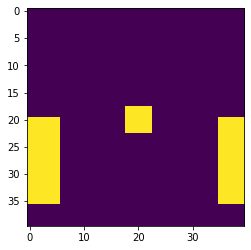

In [15]:
frame = next(frames_generator())[0]
plt.imshow(frame)

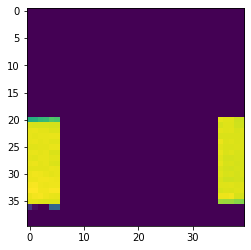

In [16]:
pred_f = ae.predict(frame.reshape(1, 40, 40)).reshape(40, 40)
plt.imshow(pred_f)

In [17]:
class Memory:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None

        init_dir = tf.keras.Input((1,), batch_size=bs)
        user_input = tf.keras.Input((None, 2), batch_size=bs)

        self.dir_hidden = tf.keras.layers.Dense(256)
        self.dir_cell_state = tf.keras.layers.Dense(256)
        self.lstm_input = tf.keras.layers.Dense(32)

        self.lstm = tf.keras.layers.GRU(
            256,
            return_sequences=True,
            stateful=stateful,
            name='lstm'
        )

        self.done_logits = tf.keras.layers.Dense(1)
        self.frame_logits1 = tf.keras.layers.Dense(128)
        self.frame_logits2 = tf.keras.layers.Dense(32)
        
        dh = self.dir_hidden(init_dir)
        dcs = self.dir_cell_state(init_dir)
        li = self.lstm_input(user_input)
        l = self.lstm(li, initial_state=[dh])
        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        self.net = tf.keras.Model([init_dir, user_input], [fl, dl])
        self.net.compile(
            loss='mse',
            optimizer='adam',
            metrics=['accuracy', 'mse']
        )

    def init(self, direction):
        self.direction = direction
        self.first_time = True

    def step(self, user_input):
        user_input = np.array([[user_input]])
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)

        direction = np.array([[self.direction]])
        direction = tf.convert_to_tensor(direction, dtype=tf.float32)

        li = self.lstm_input(user_input)

        if self.first_time:
            self.first_time = False
            dh = self.dir_hidden(direction)
            dcs = self.dir_cell_state(direction)
            l = self.lstm(li, initial_state=[dh])
        else:
            l = self.lstm(li)

        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        return fl[0].numpy(), dl[0].numpy()
    
    def copy_in_stateful_model(self):
        stateful = Memory(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
        return stateful

In [18]:
memory = Memory()
memory.net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, None, 32)     96          input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          512         input_2[0][0]                    
____________________________________________________________________________________________

In [19]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
memory.net.fit_generator(
    x=[directions.reshape(-1, 1), controls[:, 1:]],
    y=[encoded_frames[:, :-1], np.expand_dims(done[:, :-1], -1)],
    validation_split=0.1,
    batch_size=128,
    epochs=1000,
    callbacks=[tensorboard_callback]
)

In [ ]:
idx = 254
game_id = 100
plt.imshow(frames[game_id][idx])
plt.show()

pred_frames, pred_done = memory.net.predict([
    directions.reshape(-1, 1)[game_id:game_id+1],
    controls[:, 1:][game_id:game_id+1],
    encoded_frames[:, 1:][game_id:game_id+1]
])

pred_image = decoder(pred_frames[0][idx].reshape(1, -1))[0]
plt.imshow(pred_image)
plt.show()

In [ ]:
def render_training_game():
    Renderer.init_window(1000, 500)

    for game_id in range(len(encoded_frames)):
        latent_frames, _ = memory.net.predict([
            directions.reshape(-1, 1)[game_id:game_id+1],
            controls[:, 1:][game_id:game_id+1],
            encoded_frames[:, 1:][game_id:game_id+1]
        ])
        pred_frames = decoder(latent_frames[0])
        split_screens = np.concatenate(
            (frames[game_id,1:], pred_frames), axis=2
        )

        n = mpl.colors.Normalize(vmin=0, vmax=1)
        split_screens = n(split_screens)
        split_screens = cm.bwr(1 - split_screens)

        for frame in split_screens:
            if not Renderer.can_render(): return
            if Renderer.key_pressed('r'): break
            Renderer.show_frame(frame)

render_training_game()

In [ ]:
def render_actual_game():
    stateful = memory.copy_in_stateful_model()
    Renderer.init_window(500, 500)
    f = 0

    while True:
        stateful.init(random.uniform(0, 2 * math.pi))

        def step(user_input):
            pref_frame, done = stateful.step(user_input)
            return decoder.predict(pref_frame)[0], done

        while True:
            f += 1

            controls = [
                math.copysign(1, math.sin(f / 16)),
                math.copysign(1, math.sin(f / 20 + 1.2))
            ]
            frame, done = step(controls)
            done = done[0][0]
            frame = np.concatenate((
                frame,
                np.array([[done] * frame.shape[0]] * 3)
            ), axis=0)
            
            if done > 0.8:
                break

            if not Renderer.can_render(): return
            if Renderer.key_pressed('r'): break
            Renderer.show_frame(cm.bwr(1 - frame))

render_actual_game()